# Tricky local issue - how do I figure out positive testing percentage of Oak Park IL
Illinois publishes detailed positivity % at state and county levels, but not at the city level. 
Oak Park IL publishes cases counts, but nothing about test counts.

IL does publish positive cases counts and testing counts by zip code, broken down by age group, once a day, in a giant file, in a 'use it or loose it' format.


In [ ]:
# import stuff
import json
import datetime
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [ ]:
#read in file
r = requests.get("https://www.dph.illinois.gov/sitefiles/COVIDZip.json?nocache=1")
zip_json= r.text
data = json.loads(zip_json)
# parse out file date
file_date = datetime.datetime(data['LastUpdateDate']['year'], data['LastUpdateDate']['month'], data['LastUpdateDate']['day'])
file_name = file_date.strftime("%m-%d") + ".json"
f = open(file_name, "w")
f.write(r.text)
f.close()
print(file_name)
print(data.keys())
print('zip_values: '+str(data['zip_values'][0].keys()))
print('demographics: '+str(data['zip_values'][0]['demographics'].keys()))
print('demographics.age: '+str(data['zip_values'][0]['demographics']['age'][0].keys()))


We've got a rather complicated hierachical JSON data set, how do we turn this into a data frame? Also we've only read in one day of data, how do we get history?

First we'll create a dictionary of arrays to accumulate the data

In [ ]:
table = {}
table['zip'] = []
table['date'] = []
table['count'] = []
table['tested'] = []
table['percentage'] = []
table['count_14day'] = []
table['tested_14day'] = []
table['percentage_14day'] = []
age_groups = ['Unknown', '<20', '20-39', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

for age_group in age_groups:
    table[age_group+' tested'] = []
    table[age_group+' count'] = []
    table[age_group+' percentage'] = []

for age_group in age_groups:
    table[age_group+' tested_14day'] = []
    table[age_group+' count_14day'] = []
    table[age_group+' percentage_14day'] = []


Next we'll iterate over all the files we've collected, but unfortunately there are gaps. For this, we still insert a row, with empty data that gets filled later.

In [ ]:
startdate=datetime.datetime(2020,4,19,0,0,0,0)

date = startdate
# Iterate over dates, starting at 04/19
while ((datetime.datetime.now() - date).days >= 0):
    file = date.strftime("%m-%d") + ".json"
    print(file)
    try:
        open(file)
        last_good_file = file
        bad_file = False
    except:
        print('No such file: '+ file)
        bad_file = True

    if (bad_file == False or last_good_file):
        data = json.load(open(last_good_file))
        fileDate = datetime.datetime(data['LastUpdateDate']['year'], data['LastUpdateDate']['month'], data['LastUpdateDate']['day'])
        strdate= date.strftime("%m-%d")
        for zip_data in data['zip_values']:
          #  df2 = pd.DataFrame()
            if (bad_file):
                table['zip'].append( zip_data['zip'])
                table['date'].append(date)
                table['count'].append(np.NaN)
                table['tested'].append(np.NaN)
                table['percentage'].append(0)
                table['count_14day'].append(np.NaN)
                table['tested_14day'].append(np.NaN)
                table['percentage_14day'].append(0)
                age_index = 0
                for age_group in zip_data['demographics']['age']:
                    table[age_groups[age_index] + " count"].append(np.NaN)
                    table[age_groups[age_index] + " tested"].append(np.NaN)
                    table[age_groups[age_index] + " percentage"] = 0
                    table[age_groups[age_index] + " count_14day"].append(np.NaN)
                    table[age_groups[age_index] + " tested_14day"].append(np.NaN)
                    table[age_groups[age_index] + " percentage_14day"] = 0
                    age_index = age_index + 1

            else:
                table['zip'].append( zip_data['zip'])
                table['date'].append(date)
                table['count'].append(zip_data['confirmed_cases'])
                table['tested'].append(zip_data['total_tested'])
                table['percentage'].append(0)
                table['count_14day'].append(np.NaN)
                table['tested_14day'].append(np.NaN)
                table['percentage_14day'].append(0)
                age_index = 0
                for age_group in zip_data['demographics']['age']:
                    table[age_groups[age_index] + " count"].append(age_group['count'])
                    table[age_groups[age_index] + " tested"].append(age_group['tested'])
                    table[age_groups[age_index] + " percentage"] = 0
                    table[age_groups[age_index] + " count_14day"].append(np.NaN)
                    table[age_groups[age_index] + " tested_14day"].append(np.NaN)
                    table[age_groups[age_index] + " percentage_14day"] = 0
                    age_index = age_index + 1


    
    date = date + datetime.timedelta(days= 1)

In [5]:
target_zips = ['60301', '60302', '60304']
df = pd.DataFrame(table)
df = df[df['zip'].isin(target_zips)]
df['date'] = pd.to_datetime(df['date'])
df


,zip,date,count,tested,percentage,count_14day,tested_14day,percentage_14day,Unknown tested,Unknown count,...,50-59 percentage_14day,60-69 tested_14day,60-69 count_14day,60-69 percentage_14day,70-79 tested_14day,70-79 count_14day,70-79 percentage_14day,80+ tested_14day,80+ count_14day,80+ percentage_14day
118,60301,2020-04-19,11.0,50.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
119,60302,2020-04-19,84.0,512.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
120,60304,2020-04-19,32.0,226.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
507,60301,2020-04-20,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
508,60302,2020-04-20,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103818,60302,2020-09-21,439.0,13157.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
103820,60304,2020-09-21,185.0,6208.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
104898,60301,2020-09-22,54.0,1093.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
104899,60302,2020-09-22,443.0,13218.0,0,NaN,NaN,0,0.0,0.0,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0


In [6]:
df2 = df.pivot(index='date',columns='zip')
df2 = df2.interpolate().round()
df2

count                tested                  percentage        \
zip        60301  60302  60304   60301    60302   60304      60301 60302   
date                                                                       
2020-04-19  11.0   84.0   32.0    50.0    512.0   226.0          0     0   
2020-04-20  11.0   87.0   33.0    52.0    531.0   236.0          0     0   
2020-04-21  11.0   90.0   35.0    54.0    550.0   246.0          0     0   
2020-04-22  12.0   92.0   36.0    57.0    570.0   257.0          0     0   
2020-04-23  12.0   95.0   38.0    59.0    589.0   267.0          0     0   
...          ...    ...    ...     ...      ...     ...        ...   ...   
2020-09-18  54.0  437.0  184.0  1061.0  12856.0  6077.0          0     0   
2020-09-19  54.0  439.0  185.0  1077.0  12994.0  6131.0          0     0   
2020-09-20  54.0  439.0  185.0  1089.0  13088.0  6179.0          0     0   
2020-09-21  54.0  439.0  185.0  1092.0  13157.0  6208.0          0     0   
2020-09-22  54.0  443.0  185.0  1093.0  13218.0  6237.0          0     0   

                 count_14day  ... 70-79 percentage_14day 80+ tested_14day  \
zip        60304       60301  ...                  60304            60301   
date                          ...                                           
2020-04-19     0         NaN  ...                      0              NaN   
2020-04-20     0         NaN  ...                      0              NaN   
2020-04-21     0         NaN  ...                      0              NaN   
2020-04-22     0         NaN  ...                      0              NaN   
2020-04-23     0         NaN  ...                      0              NaN   
...          ...         ...  ...                    ...              ...   
2020-09-18     0         NaN  ...                      0              NaN   
2020-09-19     0         NaN  ...                      0              NaN   
2020-09-20     0         NaN  ...                      0              NaN   
2020-09-21     0         NaN  ...                      0              NaN   
2020-09-22     0         NaN  ...                      0              NaN   

                       80+ count_14day             80+ percentage_14day        \
zip        60302 60304           60301 60302 60304                60301 60302   
date                                                                            
2020-04-19   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-04-20   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-04-21   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-04-22   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-04-23   NaN   NaN             NaN   NaN   NaN                    0     0   
...          ...   ...             ...   ...   ...                  ...   ...   
2020-09-18   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-09-19   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-09-20   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-09-21   NaN   NaN             NaN   NaN   NaN                    0     0   
2020-09-22   NaN   NaN             NaN   NaN   NaN                    0     0   

                  
zip        60304  
date              
2020-04-19     0  
2020-04-20     0  
2020-04-21     0  
2020-04-22     0  
2020-04-23     0  
...          ...  
2020-09-18     0  
2020-09-19     0  
2020-09-20     0  
2020-09-21     0  
2020-09-22     0  

[157 rows x 180 columns]

In [7]:
diff = df2.diff(periods=1)
diff['percentage'] = diff['count'] / diff['tested']
for age_group in age_groups:
    diff[age_group+' percentage']  = diff[age_group+' count'] / diff[age_group+' tested']
diff

count             tested              percentage            \
zip        60301 60302 60304  60301  60302 60304      60301     60302   
date                                                                    
2020-04-19   NaN   NaN   NaN    NaN    NaN   NaN        NaN       NaN   
2020-04-20   0.0   3.0   1.0    2.0   19.0  10.0   0.000000  0.157895   
2020-04-21   0.0   3.0   2.0    2.0   19.0  10.0   0.000000  0.157895   
2020-04-22   1.0   2.0   1.0    3.0   20.0  11.0   0.333333  0.100000   
2020-04-23   0.0   3.0   2.0    2.0   19.0  10.0   0.000000  0.157895   
...          ...   ...   ...    ...    ...   ...        ...       ...   
2020-09-18  -1.0   6.0   2.0   20.0  117.0  59.0  -0.050000  0.051282   
2020-09-19   0.0   2.0   1.0   16.0  138.0  54.0   0.000000  0.014493   
2020-09-20   0.0   0.0   0.0   12.0   94.0  48.0   0.000000  0.000000   
2020-09-21   0.0   0.0   0.0    3.0   69.0  29.0   0.000000  0.000000   
2020-09-22   0.0   4.0   0.0    1.0   61.0  29.0   0.000000  0.065574   

                     count_14day  ... 70-79 percentage_14day 80+ tested_14day  \
zip            60304       60301  ...                  60304            60301   
date                              ...                                           
2020-04-19       NaN         NaN  ...                    NaN              NaN   
2020-04-20  0.100000         NaN  ...                    0.0              NaN   
2020-04-21  0.200000         NaN  ...                    0.0              NaN   
2020-04-22  0.090909         NaN  ...                    0.0              NaN   
2020-04-23  0.200000         NaN  ...                    0.0              NaN   
...              ...         ...  ...                    ...              ...   
2020-09-18  0.033898         NaN  ...                    0.0              NaN   
2020-09-19  0.018519         NaN  ...                    0.0              NaN   
2020-09-20  0.000000         NaN  ...                    0.0              NaN   
2020-09-21  0.000000         NaN  ...                    0.0              NaN   
2020-09-22  0.000000         NaN  ...                    0.0              NaN   

                       80+ count_14day             80+ percentage_14day        \
zip        60302 60304           60301 60302 60304                60301 60302   
date                                                                            
2020-04-19   NaN   NaN             NaN   NaN   NaN                  NaN   NaN   
2020-04-20   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-04-21   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-04-22   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-04-23   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
...          ...   ...             ...   ...   ...                  ...   ...   
2020-09-18   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-19   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-20   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-21   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-22   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   

                  
zip        60304  
date              
2020-04-19   NaN  
2020-04-20   0.0  
2020-04-21   0.0  
2020-04-22   0.0  
2020-04-23   0.0  
...          ...  
2020-09-18   0.0  
2020-09-19   0.0  
2020-09-20   0.0  
2020-09-21   0.0  
2020-09-22   0.0  

[157 rows x 180 columns]

In [8]:
diff['count_14day'] = diff['count'].rolling(window=14).mean()
diff['tested_14day'] = diff['tested'].rolling(window=14).mean()
diff['percentage_14day'] = diff['count_14day'] / diff['tested_14day']
diff.tail(30).head(10)

count             tested              percentage            \
zip        60301 60302 60304  60301  60302 60304      60301     60302   
date                                                                    
2020-08-24   0.0   2.0   0.0    7.0   76.0  55.0       0.00  0.026316   
2020-08-25   0.0   1.0   3.0    7.0   72.0  49.0       0.00  0.013889   
2020-08-26   0.0  10.0   1.0   11.0  112.0  67.0       0.00  0.089286   
2020-08-27   0.0   2.0   0.0    4.0   95.0  48.0       0.00  0.021053   
2020-08-28   0.0   1.0   0.0    5.0  132.0  41.0       0.00  0.007576   
2020-08-29   0.0   6.0   2.0    9.0  143.0  54.0       0.00  0.041958   
2020-08-30   0.0   5.0   2.0    9.0  142.0  54.0       0.00  0.035211   
2020-08-31   0.0   2.0   1.0    4.0   95.0  60.0       0.00  0.021053   
2020-09-01   1.0   2.0   2.0    4.0   50.0  33.0       0.25  0.040000   
2020-09-02   0.0  -1.0   5.0    7.0  107.0  67.0       0.00 -0.009346   

                     count_14day  ... 70-79 percentage_14day 80+ tested_14day  \
zip            60304       60301  ...                  60304            60301   
date                              ...                                           
2020-08-24  0.000000    0.285714  ...                    0.0              NaN   
2020-08-25  0.061224    0.285714  ...                    0.0              NaN   
2020-08-26  0.014925    0.214286  ...                    0.0              NaN   
2020-08-27  0.000000    0.214286  ...                    0.0              NaN   
2020-08-28  0.000000    0.214286  ...                    0.0              NaN   
2020-08-29  0.037037    0.214286  ...                    0.0              NaN   
2020-08-30  0.037037    0.214286  ...                    0.0              NaN   
2020-08-31  0.016667    0.214286  ...                    0.0              NaN   
2020-09-01  0.060606    0.285714  ...                    0.0              NaN   
2020-09-02  0.074627    0.285714  ...                    0.0              NaN   

                       80+ count_14day             80+ percentage_14day        \
zip        60302 60304           60301 60302 60304                60301 60302   
date                                                                            
2020-08-24   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-25   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-26   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-27   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-28   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-29   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-30   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-08-31   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-01   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   
2020-09-02   NaN   NaN             NaN   NaN   NaN                  0.0   0.0   

                  
zip        60304  
date              
2020-08-24   0.0  
2020-08-25   0.0  
2020-08-26   0.0  
2020-08-27   0.0  
2020-08-28   0.0  
2020-08-29   0.0  
2020-08-30   0.0  
2020-08-31   0.0  
2020-09-01   0.0  
2020-09-02   0.0  

[10 rows x 180 columns]

In [9]:

for age_group in age_groups:
    diff[age_group+' percentage']  = diff[age_group+' count'] / diff[age_group+' tested']
    diff[age_group+' count_14day'] = diff['count'].rolling(window=14).mean()
    diff[age_group+' tested_14day'] = diff['tested'].rolling(window=14).mean()
    diff[age_group+' percentage_14day']  = diff[age_group+' count_14day'] / diff[age_group+' tested_14day']
diff.to_csv('zip_detail_all.csv')


In [10]:
dftotals = diff.transpose()
dftotals

date                        2020-04-19  2020-04-20  2020-04-21  2020-04-22  \
                     zip                                                     
count                60301         NaN         0.0         0.0         1.0   
                     60302         NaN         3.0         3.0         2.0   
                     60304         NaN         1.0         2.0         1.0   
tested               60301         NaN         2.0         2.0         3.0   
                     60302         NaN        19.0        19.0        20.0   
...                                ...         ...         ...         ...   
80+ count_14day      60302         NaN         NaN         NaN         NaN   
                     60304         NaN         NaN         NaN         NaN   
80+ percentage_14day 60301         NaN         NaN         NaN         NaN   
                     60302         NaN         NaN         NaN         NaN   
                     60304         NaN         NaN         NaN         NaN   

date                        2020-04-23  2020-04-24  2020-04-25  2020-04-26  \
                     zip                                                     
count                60301         0.0         0.0         0.0         0.0   
                     60302         3.0         3.0         1.0         2.0   
                     60304         2.0         1.0         2.0         1.0   
tested               60301         2.0         2.0         2.0         2.0   
                     60302        19.0        19.0        24.0        23.0   
...                                ...         ...         ...         ...   
80+ count_14day      60302         NaN         NaN         NaN         NaN   
                     60304         NaN         NaN         NaN         NaN   
80+ percentage_14day 60301         NaN         NaN         NaN         NaN   
                     60302         NaN         NaN         NaN         NaN   
                     60304         NaN         NaN         NaN         NaN   

date                        2020-04-27  2020-04-28  ...  2020-09-13  \
                     zip                            ...               
count                60301         0.0         1.0  ...    0.000000   
                     60302         1.0         4.0  ...    2.000000   
                     60304         2.0         1.0  ...    1.000000   
tested               60301         2.0         4.0  ...   12.000000   
                     60302        24.0        35.0  ...  112.000000   
...                                ...         ...  ...         ...   
80+ count_14day      60302         NaN         NaN  ...    2.785714   
                     60304         NaN         NaN  ...    1.928571   
80+ percentage_14day 60301         NaN         NaN  ...    0.076336   
                     60302         NaN         NaN  ...    0.022059   
                     60304         NaN         NaN  ...    0.033708   

date                        2020-09-14  2020-09-15  2020-09-16  2020-09-17  \
                     zip                                                     
count                60301    0.000000    0.000000    0.000000    0.000000   
                     60302    1.000000    2.000000    3.000000    1.000000   
                     60304    2.000000    0.000000    0.000000    6.000000   
tested               60301   11.000000    3.000000    7.000000    6.000000   
                     60302  112.000000   67.000000  102.000000  110.000000   
...                                ...         ...         ...         ...   
80+ count_14day      60302    2.714286    2.714286    3.000000    2.857143   
                     60304    2.000000    1.857143    1.500000    1.857143   
80+ percentage_14day 60301    0.072464    0.065693    0.065693    0.058394   
                     60302    0.021289    0.021088    0.023372    0.021657   
                     60304    0.035354    0.032828    0.026820    0.032828   

date                        202

In [11]:
dftotals = dftotals.sum(level=0)
dftotals

date,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,...,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22
count,0.0,4.000000,5.000000,4.000000,5.000000,4.000000,3.000000,3.000000,3.000000,6.000000,...,3.000000,3.000000,2.000000,3.000000,7.000000,7.000000,3.000000,0.000000,0.000000,4.000000
tested,0.0,31.000000,31.000000,34.000000,31.000000,31.000000,44.000000,43.000000,44.000000,56.000000,...,174.000000,174.000000,103.000000,167.000000,168.000000,196.000000,208.000000,154.000000,101.000000,91.000000
percentage,0.0,0.257895,0.357895,0.524242,0.357895,0.257895,0.152778,0.142512,0.152778,0.423109,...,0.037857,0.048144,0.029851,0.029412,0.124476,0.035180,0.033011,0.000000,0.000000,0.065574
count_14day,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.428571,5.428571,5.214286,5.142857,5.285714,5.571429,5.357143,4.928571,4.357143,4.428571
tested_14day,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,192.857143,193.928571,195.071429,194.071429,198.285714,178.928571,173.714286,164.642857,163.428571,153.500000
percentage_14day,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.132103,0.129106,0.119609,0.115886,0.112879,0.116442,0.107858,0.105269,0.098098,0.098911
Unknown tested,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Unknown count,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Unknown percentage,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<20 tested,0.0,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,...,24.000000,24.000000,56.000000,27.000000,24.000000,25.000000,22.000000,27.000000,13.000000,9.000000


In [12]:

dftotals = dftotals.transpose()
dftotals

,count,tested,percentage,count_14day,tested_14day,percentage_14day,Unknown tested,Unknown count,Unknown percentage,<20 tested,...,50-59 percentage_14day,60-69 tested_14day,60-69 count_14day,60-69 percentage_14day,70-79 tested_14day,70-79 count_14day,70-79 percentage_14day,80+ tested_14day,80+ count_14day,80+ percentage_14day
date,,,,,,,,,,,,,,,,,,,,,
2020-04-19,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-20,4.0,31.0,0.257895,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-21,5.0,31.0,0.357895,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-22,4.0,34.0,0.524242,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-04-23,5.0,31.0,0.357895,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-18,7.0,196.0,0.035180,5.571429,178.928571,0.116442,0.0,0.0,0.0,25.0,...,0.116442,178.928571,5.571429,0.116442,178.928571,5.571429,0.116442,178.928571,5.571429,0.116442
2020-09-19,3.0,208.0,0.033011,5.357143,173.714286,0.107858,0.0,0.0,0.0,22.0,...,0.107858,173.714286,5.357143,0.107858,173.714286,5.357143,0.107858,173.714286,5.357143,0.107858
2020-09-20,0.0,154.0,0.000000,4.928571,164.642857,0.105269,0.0,0.0,0.0,27.0,...,0.105269,164.642857,4.928571,0.105269,164.642857,4.928571,0.105269,164.642857,4.928571,0.105269


In [13]:
#fix up fields that don't sum properly

dftotals['percentage'] = dftotals['count'] / dftotals['tested']
for age_group in age_groups:
    dftotals[age_group+' percentage']  = dftotals[age_group+' count'] / dftotals[age_group+' tested']

dftotals['count_14day'] = dftotals['count'].rolling(window=14).mean()
dftotals['tested_14day'] = dftotals['tested'].rolling(window=14).mean()
dftotals['percentage_14day'] = dftotals['count_14day'] / dftotals['tested_14day']

for age_group in age_groups:
    dftotals[age_group+' percentage']  = dftotals[age_group+' count'] / dftotals[age_group+' tested']
    dftotals[age_group+' count_14day'] = dftotals['count'].rolling(window=14).mean()
    dftotals[age_group+' tested_14day'] = dftotals['tested'].rolling(window=14).mean()
    dftotals[age_group+' percentage_14day']  = dftotals[age_group+' count_14day'] / dftotals[age_group+' tested_14day']

dftotals.to_csv('zip_rollup_all.csv')

(0.0, 0.14705882352941174)

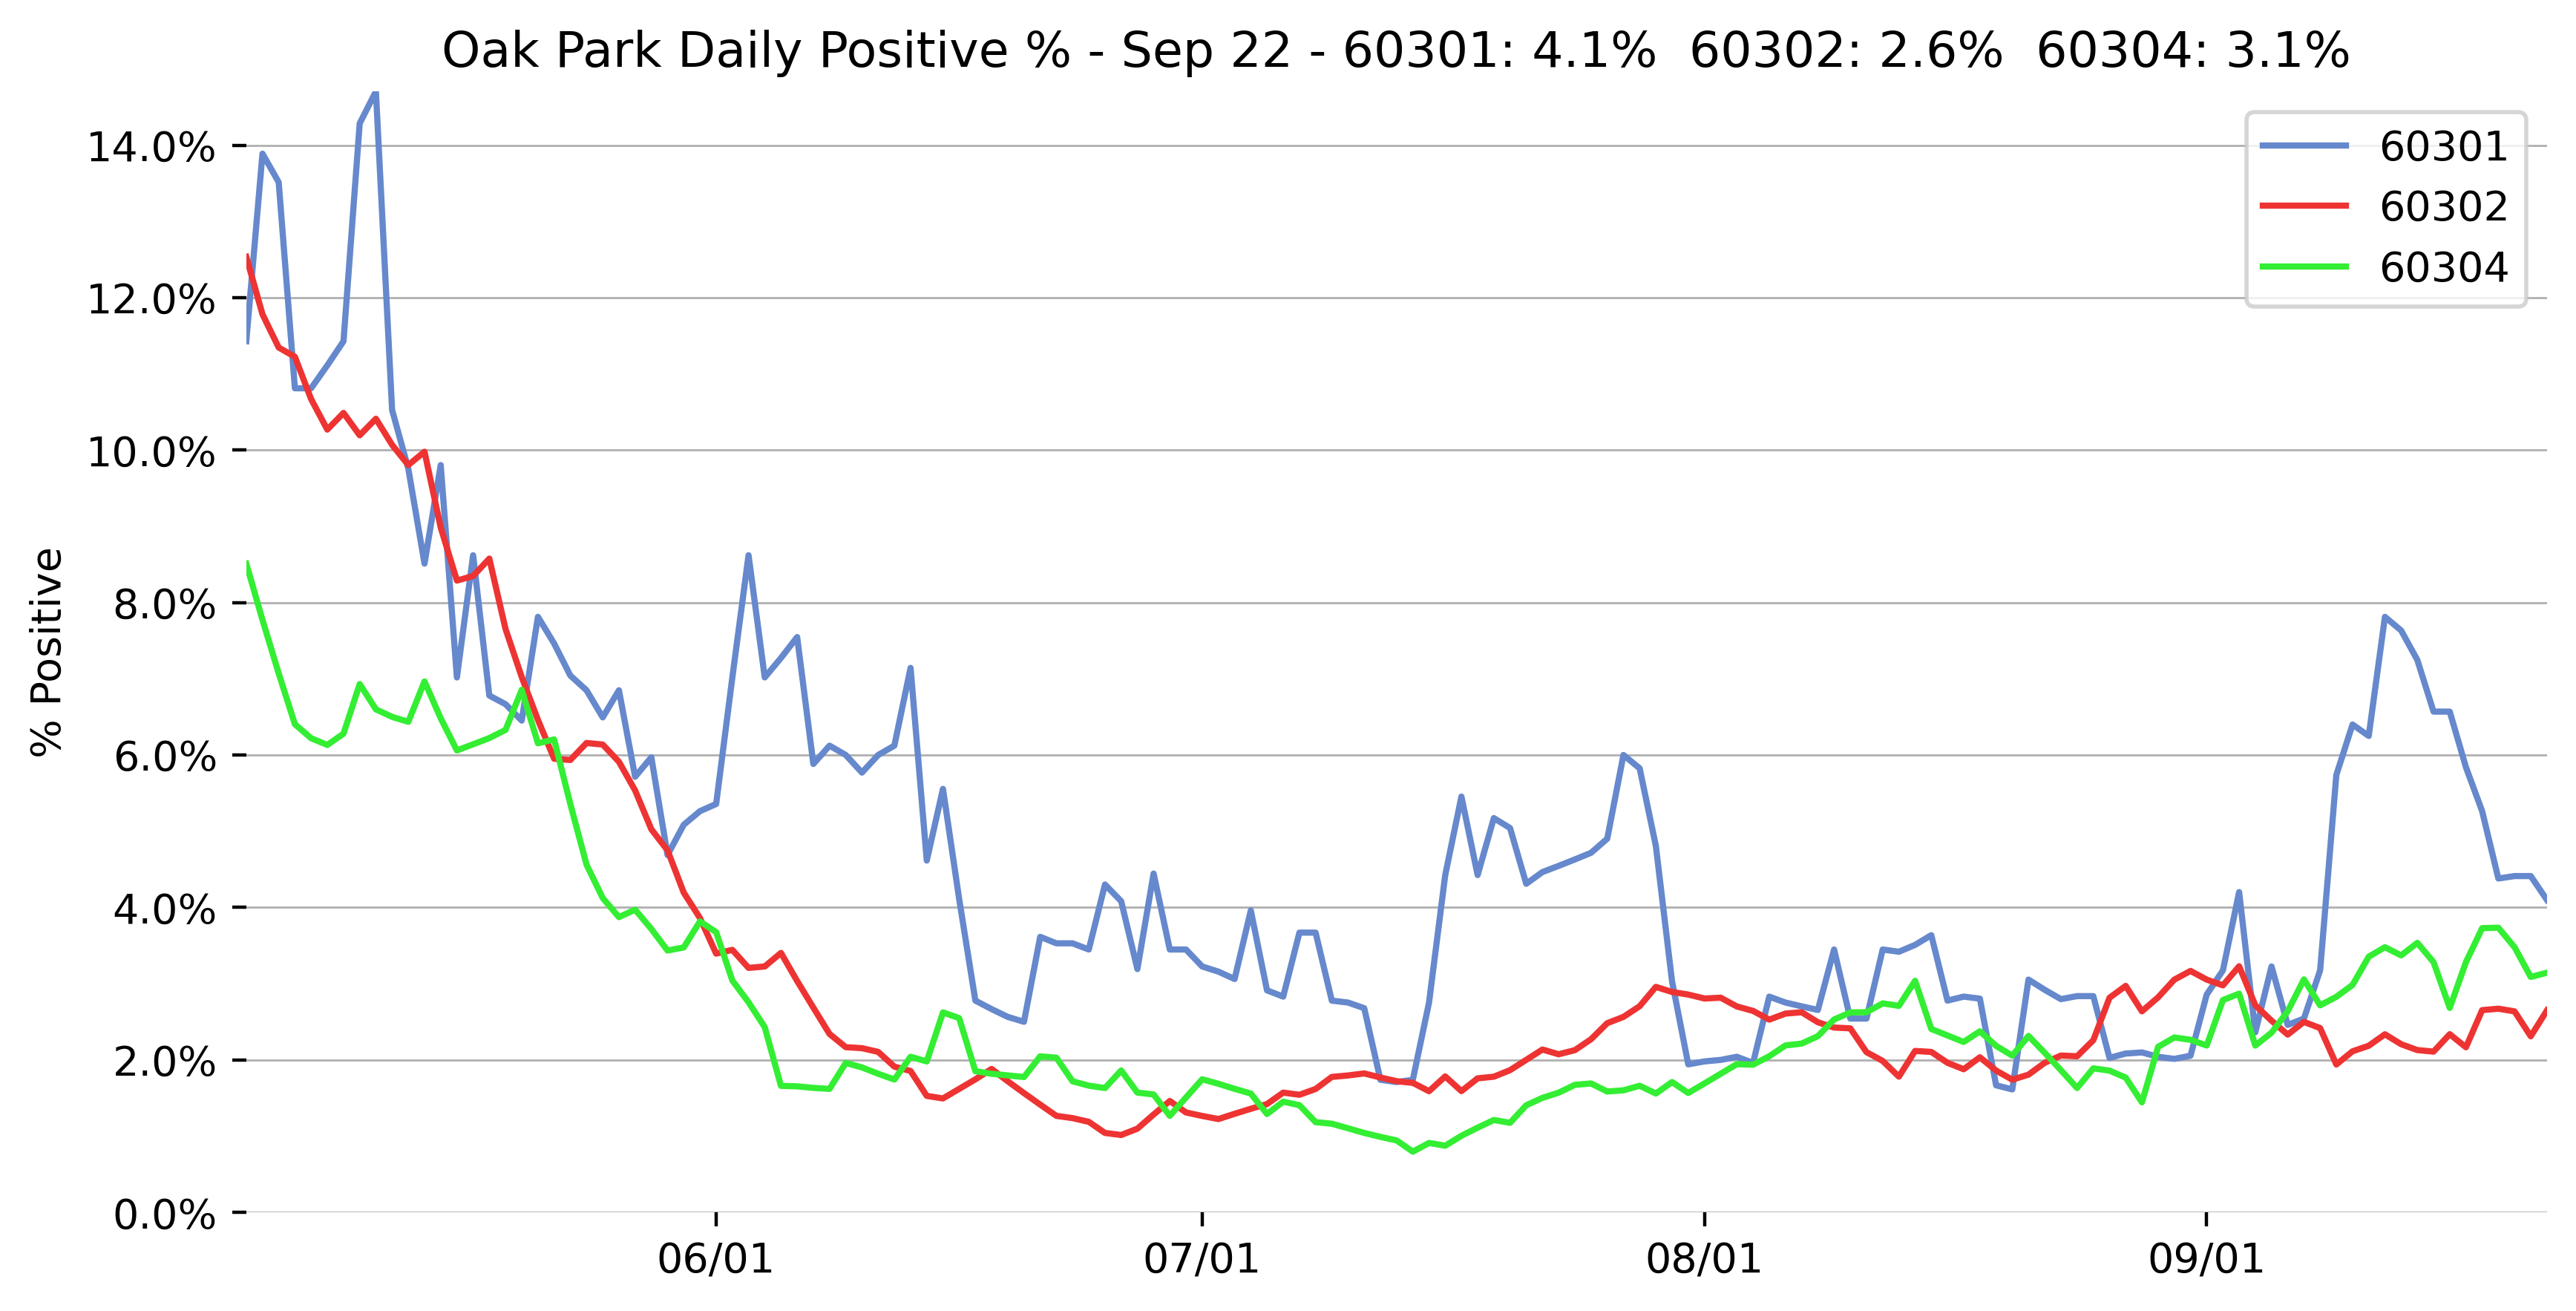

In [14]:
# Make a zip code breakout of positivity %
df = pd.read_csv('zip_detail_all.csv',  header=[0,1], index_col=0, parse_dates=True)

plt.figure(figsize=(10, 5), dpi=400)
plt.box(on=None)
plt.margins(0)
width = 0.75
plt.plot(df.index, df['percentage_14day']['60301'], color='#6688cc', label="60301")
plt.plot(df.index, df['percentage_14day']['60302'], color='#EE3333', label="60302")
plt.plot(df.index, df['percentage_14day']['60304'], color='#33EE33', label="60304")
plt.ylabel("% Positive")
plt.legend(loc='best')

current_date = df.tail(1)['percentage_14day']['60301'].index[0]
current_value_60301 = df.tail(1)['percentage_14day']['60301'][0]
current_value_60302 = df.tail(1)['percentage_14day']['60302'][0]
current_value_60304 = df.tail(1)['percentage_14day']['60304'][0]

plt.title('Oak Park Daily Positive % - '+'{:%b %-d} - 60301: {:0.1f}%  60302: {:0.1f}%  60304: {:0.1f}%'.format(current_date, 100* current_value_60301, 100* current_value_60302, 100* current_value_60304))
plt.grid(axis='y', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.ylim(0)



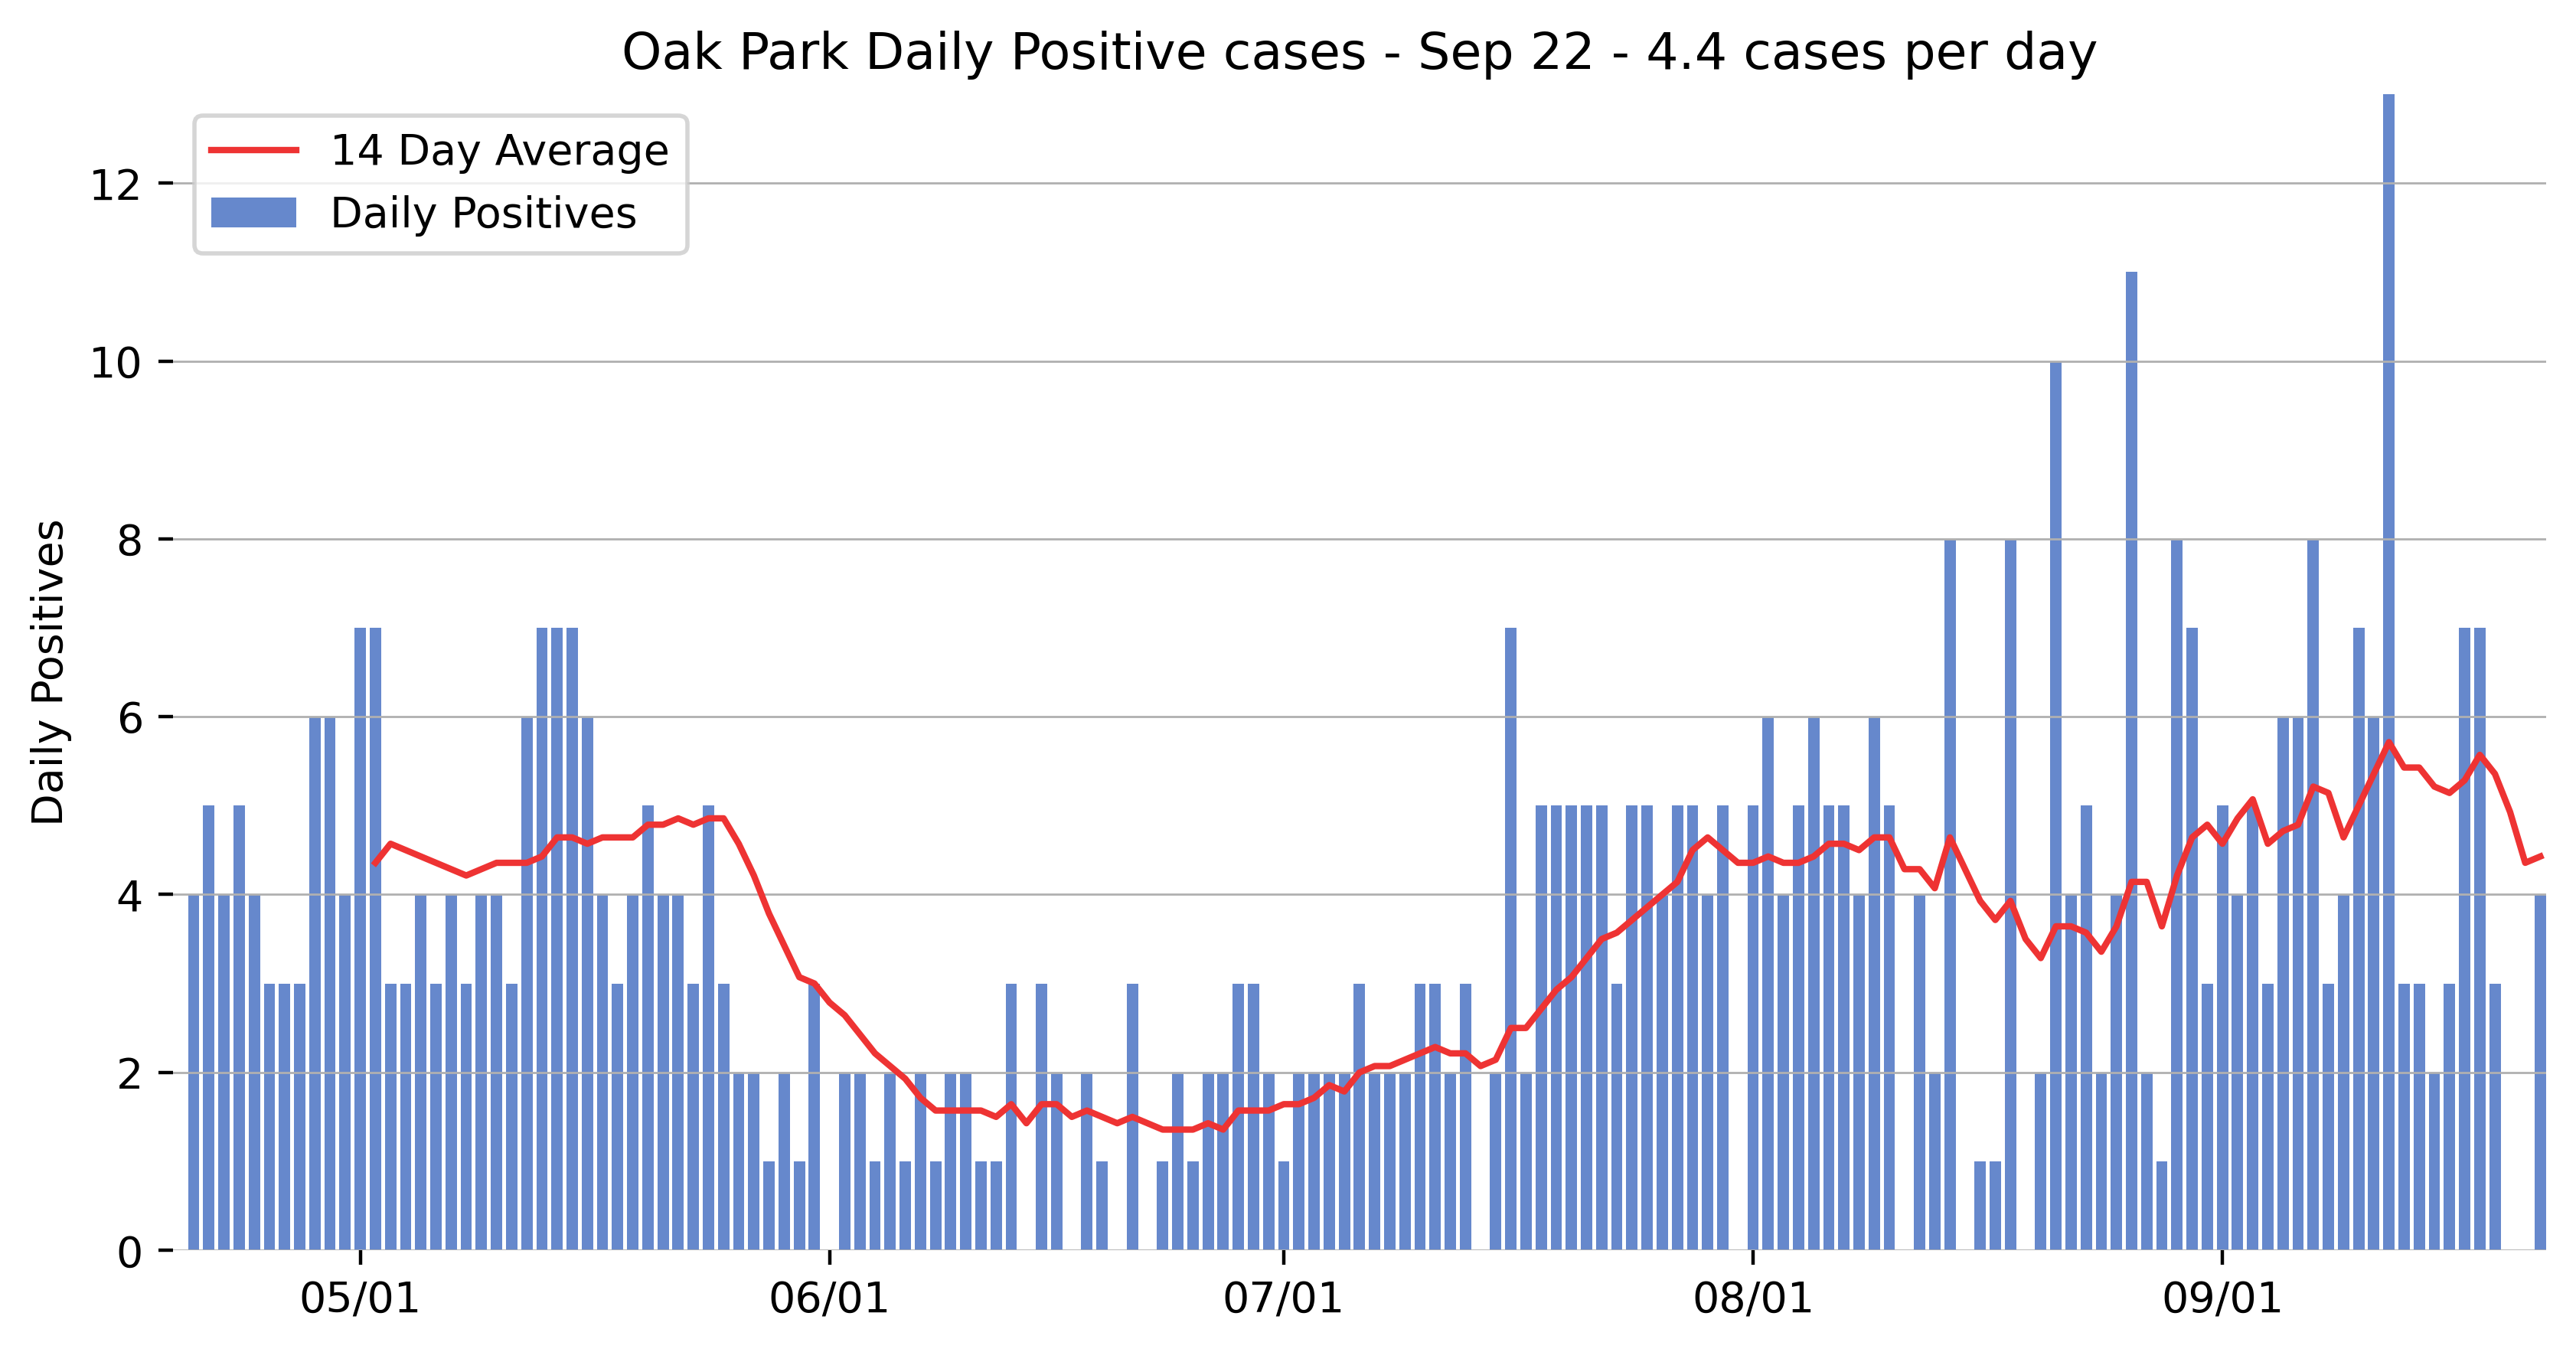

In [15]:
#######################################################################################
# Positives/Positive testing %
#######################################################################################
df = pd.read_csv('zip_rollup_all.csv', header=[0], index_col=0, parse_dates=True)
plt.close()
plt.figure(figsize=(10, 5), dpi=400)
plt.box(0)
plt.margins(0)
width = 0.75
plt.bar(df.index, df['count'], width, color='#6688cc', label="Daily Positives")
plt.plot(df.index, df['count_14day'], color='#EE3333', label="14 Day Average")
plt.ylabel("Daily Positives")
plt.legend(loc='best')
current_value = df.tail(1)['count_14day'][0]
current_date = df.tail(1)['count_14day'].index[0]

plt.title('Oak Park Daily Positive cases - '+'{:%b %-d} - {:0.1f} cases per day'.format(current_date,current_value))
plt.grid(axis='y', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

